# Data Pre-Preprocessing

After completing the data set selection and initial preparation, I continued refining the dataset. I made the decision to correlate Second Stage debates with corresponding divisions. Any bill that is debated has to go through this stage in order to either pass the stage and move closer to being enacted, or being voted down at this stage and not proceeding. I chose this particular correlation because it is identifiable in both the debates and divisions data, and being early in the process is relatively plentiful compared to other stages.

Previously, data was extracted from Oireachtas APIs into JSON files, from which XML files were extracted for full text of debates. This was done for the entirety of the 32nd Dail (March 10 2016-January 14 2020).


## 1. Extracting data from xml files

I used the BeautifulSoup library to read all the XML files containing full debate transcripts from a text file containing all of the XML file names.

In [1]:
from bs4 import BeautifulSoup as bso
import csv

I extracted information about the debate date, debate section, bill reference, speaker ID and the text of a single utterance, restricting it only to Second Stage debates.

In [5]:
f2= csv.writer(open("debates2.csv", "w", newline=""))
f2.writerow(["Debate_Date","Debate_Section_ID","Bill_Reference", "Speaker_ID", "Utterance"])

with open("xml_filenames_all.txt", "r", errors='ignore') as filenames_file:
    filenames = filenames_file.readlines()
    for filename in filenames:
        content = []
        with open("xml/"+filename.strip(), "r", encoding='utf-8', errors='ignore') as file:
            content = file.readlines()
            content = "".join(content)
            soup = bso(content, "lxml")
                         
            dateblock = soup.find("docdate")
            date = dateblock.get("date")
            dbsections = soup.find_all("debatesection")
            for dbsection in dbsections:
                refersto = dbsection.get('refersto')
                if type(refersto) == str: 
                    if refersto.endswith("2"):
                        sectionid = dbsection.get ('eid')
                
                        speeches = dbsection.find_all("speech")
                        for speech in speeches:
                            speaker = speech.get("by")
                            if len(speaker) > 1:
                                utterances = speech.find_all('p')
                                for utterance in utterances:
                                    f2.writerow([date, sectionid, refersto[:-1], speaker, utterance.get_text()])

I extracted information about the vote date, vote section, bill reference, speaker ID and the type of vote (Yes/No/Abstain), restricting it only to Second Stage votes corresponding to the debates previously extracted.

In [6]:
f= csv.writer(open("divisions2.csv", "w", newline=""))
f.writerow(["Vote_Date","Vote_Section_ID","Bill_Reference", "Speaker_ID", "Vote", "Question_Put"])

with open("xml_filenames_all.txt", "r", errors='ignore') as filenames_file:
    filenames = filenames_file.readlines()
    for filename in filenames:
        content = []
        with open("xml/"+filename.strip(), "r", encoding='utf-8', errors='ignore') as file:
            content = file.readlines()
            content = "".join(content)
            soup = bso(content, "lxml")
            
            # votes
            dateblock = soup.find("docdate")
            date = dateblock.get("date")
            dbsections = soup.find_all("debatesection", {"name": "division"})
            for dbsection in dbsections:
               

                firstsummary = dbsection.find("summary")
                questionput = firstsummary.get_text()
                if questionput.lower().find("second time") != -1:
                    refersto = dbsection.get('refersto')
                    if type(refersto) == str: 
                        sectionid = dbsection.get ('eid')
                    else:
                        continue

                    ta_votes = dbsection.find("debatesection", {"name": "ta"})
                    ta_voters = ta_votes.find_all("person")
                    for ta_voter in ta_voters:
                        ta_voter_id = ta_voter.get("refersto")
                        f.writerow([date, sectionid, refersto, ta_voter_id, "1", questionput])


                    nil_votes = dbsection.find("debatesection", {"name": "nil"})
                    nil_voters = nil_votes.find_all("person")
                    for nil_voter in nil_voters:
                        nil_voter_id = nil_voter.get("refersto")
                        f.writerow([date, sectionid, refersto, nil_voter_id, "0", questionput])

                    staon_votes = dbsection.find("debatesection", {"name": "staon"})
                    if not staon_votes is None:
                        staon_voters = staon_votes.find_all("person")
                        for staon_voter in staon_voters:
                            staon_voter_id = staon_voter.get("refersto")
                            if len(staon_voter_id) > 1:
                                f.writerow([date, sectionid, refersto, staon_voter_id, "2", questionput])

## 2. Merging debate and division data

I imported the debates and divisions data into two Pandas dataframes.

In [9]:
import pandas as pd
debates = pd.read_csv("debates2.csv", index_col=False, warn_bad_lines=True, error_bad_lines=False)

divisions = pd.read_csv("divisions2.csv", index_col=False, warn_bad_lines=True, error_bad_lines=False)

In [10]:
debates.head()

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance
0,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,"Tairgim: ""Go léifear an Bille an Dara hUair an..."
1,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,"Mar Aire Stáit le freagracht as an nGaeilge, ..."
2,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,Sílim gur fiú cúpla focal a rá faoin gcúlra a...
3,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,Sular dréachtaíodh an Bille seo le leasú a dh...
4,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,Is é an bunaidhm atá againn leis an mBille nu...


In [11]:
divisions.head()

,Vote_Date,Vote_Section_ID,Bill_Reference,Speaker_ID,Vote,Question_Put
0,2019-12-12,dbsect_26,#bill.2019.99.dail.,#BobbyAylward,1,"Question put: ""That the Bill be now read a Sec..."
1,2019-12-12,dbsect_26,#bill.2019.99.dail.,#MickBarry,1,"Question put: ""That the Bill be now read a Sec..."
2,2019-12-12,dbsect_26,#bill.2019.99.dail.,#JohnBrady,1,"Question put: ""That the Bill be now read a Sec..."
3,2019-12-12,dbsect_26,#bill.2019.99.dail.,#JohnBrassil,1,"Question put: ""That the Bill be now read a Sec..."
4,2019-12-12,dbsect_26,#bill.2019.99.dail.,#DeclanBreathnach,1,"Question put: ""That the Bill be now read a Sec..."


### 2.1. Identifying and limiting utterance language

I imported the <b>langid</b> library so I could identify the language used in the utterances. A small percentage of utterances (about 1%) were identified as language other than English (mostly Irish and a few other languages that on inspection were mostly short phrases that have been misidentified in error). These were removed for better accuracy for sentiment analysis.

In [12]:
from langid.langid import LanguageIdentifier, model
language_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
debates['Language'] = 0

for index, row in debates.iterrows():
    language = language_identifier.classify(row['Utterance'])
    debates.loc[index, 'Language'] = language[0]
    
debates.head(5)
    

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language
0,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,"Tairgim: ""Go léifear an Bille an Dara hUair an...",ga
1,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,"Mar Aire Stáit le freagracht as an nGaeilge, ...",ga
2,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,Sílim gur fiú cúpla focal a rá faoin gcúlra a...,ga
3,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,Sular dréachtaíodh an Bille seo le leasú a dh...,ga
4,2019-12-18,dbsect_5,#bill.2019.104.dail.,#SeanKyne,Is é an bunaidhm atá againn leis an mBille nu...,ga


In [13]:
debates.groupby(by='Language').agg('count')

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance
Language,,,,,
cs,2,2,2,2,2
de,33,33,33,33,33
en,44832,44832,44832,44832,44832
es,5,5,5,5,5
et,3,3,3,3,3
eu,1,1,1,1,1
fi,2,2,2,2,2
fo,1,1,1,1,1
fr,18,18,18,18,18


In [14]:
import numpy as np

for index, row in debates.iterrows():
    if row['Language'] != 'en':
        debates.loc[index, 'Language'] = np.nan
        
debates = debates.dropna()
debates.head()

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language
62,2019-12-18,dbsect_39,#bill.2017.17.dail.,#PatTheCopeGallagher,I must now deal with a postponed division rela...,en
63,2019-12-12,dbsect_25,#bill.2019.99.dail.,#DeclanBreathnach,I must now deal with a postponed division rela...,en
64,2019-12-12,dbsect_31,#bill.2019.100.dail.,#SimonHarris,"I move: ""That the Bill be now read a Second Ti...",en
65,2019-12-12,dbsect_31,#bill.2019.100.dail.,#SimonHarris,I am pleased to have the opportunity to intro...,en
66,2019-12-12,dbsect_31,#bill.2019.100.dail.,#SimonHarris,I think today of people like Róisín and Mark ...,en


The cleaned version of the debates file was merged with the votes file, matching them on the bill reference and speaker ID columns.

In [15]:
debates_divisions = pd.merge(debates, divisions, how="inner", on=["Bill_Reference", "Speaker_ID"])

In [16]:
debates_divisions.head()

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language,Vote_Date,Vote_Section_ID,Vote,Question_Put
0,2019-12-12,dbsect_25,#bill.2019.99.dail.,#DeclanBreathnach,I must now deal with a postponed division rela...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec..."
1,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,"Before I call on the next group of speakers, I...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec..."
2,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,Rachaimid ar aghaidh go dtí Solidarity-People ...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec..."
3,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoinOBroin,"I move: ""That the Bill be now read a Second Ti...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec..."
4,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoinOBroin,"As everybody in this Chamber knows, rents are...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec..."


### 2.2. Importing & merging metadata

Member metadata that was retrieved in JSON format from the Oireacthas Open Data portal was converted to CSV, including the name of the TD, their constituency and party.

In [17]:
import json

In [18]:
f= csv.writer(open("members.csv", "w", newline=""))
 
with open('members.json') as json_file:
    members_data = json.load(json_file)
    f.writerow(['Speaker_ID','FullName','Constituency','Party'])
    for member in members_data['results']:
        f.writerow(["#"+member['member']['pId'], member['member']['fullName'], member['member']['memberships'][0]['membership']['represents'][0]['represent']['representCode'], member['member']['memberships'][0]['membership']['parties'][0]['party']['partyCode']])

Bill metadata from the same source was converted to CSV, including the bill reference, the short name of the bill, the type of the bill.

In [20]:
f= csv.writer(open("bills.csv", "w", newline=""))
 
with open('bills.json', encoding='utf-8') as json_file:
    bills_data = json.load(json_file)
    f.writerow(['Bill_Reference','Bill_Short_Name','Bill_Type'])
    for bill in bills_data['results']:
        f.writerow(["#bill." +bill['bill']['billYear']+"."+ bill['bill']['billNo']+".dail.", bill['bill']['shortTitleEn'], bill['bill']['source']])

Members metadata was merged with the debates_divisions dataset.

In [21]:
members = pd.read_csv("members.csv", index_col=False, warn_bad_lines=True, error_bad_lines=False)

debates_divisions_members = debates_divisions.merge(members, on='Speaker_ID')

debates_divisions_members.head()

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language,Vote_Date,Vote_Section_ID,Vote,Question_Put,FullName,Constituency,Party
0,2019-12-12,dbsect_25,#bill.2019.99.dail.,#DeclanBreathnach,I must now deal with a postponed division rela...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil
1,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,"Before I call on the next group of speakers, I...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil
2,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,Rachaimid ar aghaidh go dtí Solidarity-People ...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil
3,2019-04-09,dbsect_33,#bill.2018.121.dail.,#DeclanBreathnach,Please do not interrupt.,en,2019-04-11,dbsect_64,0,"Question again put: ""That the Bill be now read...",Declan Breathnach,Louth,Fianna_Fáil
4,2018-06-27,dbsect_29,#bill.2017.156.dail.,#DeclanBreathnach,I compliment Deputy O'Callaghan on bringing th...,en,2018-06-28,dbsect_22,1,"Question again put: ""That the Bill be now read...",Declan Breathnach,Louth,Fianna_Fáil


The debates_divisions_members dataset was merged with bills metadata.

In [23]:
bills = pd.read_csv("bills.csv", index_col=False, warn_bad_lines=True, error_bad_lines=False)

debates_divisions_members_bills = debates_divisions_members.merge(bills, on="Bill_Reference")

debates_divisions_members_bills.to_csv("debates_divisions_members_bills.csv", index=False)

In [24]:
debates_divisions_members_bills.head()

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language,Vote_Date,Vote_Section_ID,Vote,Question_Put,FullName,Constituency,Party,Bill_Short_Name,Bill_Type
0,2019-12-12,dbsect_25,#bill.2019.99.dail.,#DeclanBreathnach,I must now deal with a postponed division rela...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member
1,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,"Before I call on the next group of speakers, I...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member
2,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,Rachaimid ar aghaidh go dtí Solidarity-People ...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member
3,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoinOBroin,"I move: ""That the Bill be now read a Second Ti...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member
4,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoinOBroin,"As everybody in this Chamber knows, rents are...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member


### 2.3. Merging speakers and utterances

A column counting the number of utterances was added to the dataframe, and the utterances were grouped together similar to the approach taken by Abercrombie and Batista-Navarro (2020) for their ParlVote Corpus, with duplicate fields resulting from this step then removed from the dataset. I grouped by all columns other than <i>Debate_Date</i> and <i>Debate_Section_ID</i> in order to combine everything each individual speaker said regarding a particular bill (as debates may take place over a number of days and in separate sections in the data format)

In [25]:
utterances = pd.read_csv("debates_divisions_members_bills.csv") 
  
utterances['Utterance_Count'] = utterances.groupby(["Bill_Reference", "Speaker_ID", "Vote_Date", "Vote_Section_ID", "Vote", "Question_Put", "FullName", "Constituency", "Party"])['Utterance'].transform('count')

utterances['Utterance'] = utterances.groupby(["Bill_Reference", "Speaker_ID", "Vote_Date", "Vote_Section_ID", "Vote", "Question_Put", "FullName", "Constituency", "Party"])['Utterance'].transform(lambda x: ' '.join(x))


utterances = utterances.drop_duplicates(subset='Utterance', keep="last")   

utterances = utterances.dropna()

utterances.head()

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language,Vote_Date,Vote_Section_ID,Vote,Question_Put,FullName,Constituency,Party,Bill_Short_Name,Bill_Type,Utterance_Count
2,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,I must now deal with a postponed division rela...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,3
29,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoinOBroin,"I move: ""That the Bill be now read a Second Ti...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,27
31,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeniseMitchell,Rents in the State are too high and are contin...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Denise Mitchell,Dublin-Bay-North,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2
35,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DonnchadhOLaoghaire,Renting in this economy and society is extreme...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Donnchadh Ó Laoghaire,Cork-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4
39,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DavidCullinane,I said last week that people outside this Hous...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",David Cullinane,Waterford,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4


## 3. Cleaning data for sentiment analysis and bag-of-words transformation

In this step, utterance data in the dataset was cleaned up, tokenized and the utterance text was stemmed using the <b>NLTK</b> library. 

The following steps took place:
- accents were removed from words (which would help with readability of occassionally used Irish words)
- punctuation was removed
- text was made lowercase
- digits such as years were removed
- stop words were removed
- the resulting text was tokenized
- the text was then stemmed

In [26]:

import nltk
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
from nltk.stem import PorterStemmer
import string
import unicodedata
import re

ps = nltk.porter.PorterStemmer()

utterances['Clean_Utterance'] = 0
for index, row in utterances.iterrows():
    raw_utterance = row['Utterance']
    
    no_accents = unicodedata.normalize('NFKD', raw_utterance).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    no_punctuation = "".join([i for i in no_accents if i not in string.punctuation])
    lowercase = no_punctuation.lower()
    no_digits = re.sub(r'[^a-zA-z\s]', '', lowercase)
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(no_digits)  
    no_stopwords = [w for w in word_tokens if not w in stop_words] 
    stemmed_text = ' '.join([ps.stem(word) for word in no_stopwords])
    utterances.loc[index, 'Clean_Utterance'] = stemmed_text
        
utterances.head(10)   

 
    

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language,Vote_Date,Vote_Section_ID,Vote,Question_Put,FullName,Constituency,Party,Bill_Short_Name,Bill_Type,Utterance_Count,Clean_Utterance
2,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,I must now deal with a postponed division rela...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,3,must deal postpon divis relat second stage ren...
29,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoinOBroin,"I move: ""That the Bill be now read a Second Ti...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,27,move bill read second time everybodi chamber k...
31,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeniseMitchell,Rents in the State are too high and are contin...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Denise Mitchell,Dublin-Bay-North,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2,rent state high continu rise time freez rent p...
35,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DonnchadhOLaoghaire,Renting in this economy and society is extreme...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Donnchadh Ó Laoghaire,Cork-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4,rent economi societi extrem hard even one dece...
39,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DavidCullinane,I said last week that people outside this Hous...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",David Cullinane,Waterford,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4,said last week peopl outsid hous sick tire pol...
42,2019-12-10,dbsect_38,#bill.2019.99.dail.,#ImeldaMunster,Every single day of every single week in almos...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Imelda Munster,Louth,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,3,everi singl day everi singl week almost everi ...
44,2019-12-10,dbsect_38,#bill.2019.99.dail.,#LouiseOReilly,"Despite what the Minister says, I am not certa...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Louise O'Reilly,Dublin-Fingal,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2,despit minist say certain truli understand imp...
70,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoghanMurphy,I thank Deputy Ó Broin for bringing forward th...,en,2019-12-12,dbsect_26,0,"Question put: ""That the Bill be now read a Sec...",Eoghan Murphy,Dublin-Bay-South,Fine_Gael,Rent Freeze (Fair Rent) Bill 2019,Private Member,26,thank deputi broin bring forward bill rent hig...
77,2019-12-10,dbsect_38,#bill.2019.99.dail.,#AengusOSnodaighSF,We are supporting hundreds more. The Minister ...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Aengus Ó Snodaigh,Dublin-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,7,support hundr minist misrepres newspap biggest...
89,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DarraghOBrien,We all know that an entire generation now risk...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Darragh O'Brien,Dublin-Fingal,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,12,know entir gener risk perman lock rental trap ...


## 4. Sentiment analysis

The <b>TextBlob</b> library was used to predict sentiment polarity and subjectivity for the combined utterances.

In [27]:
import textblob


In [28]:
from textblob.sentiments import PatternAnalyzer
from textblob import TextBlob
utterances['Sentiment_Polarity'] = 0
utterances['Sentiment_Subjectivity'] = 0

for index, row in utterances.iterrows():
    blob = TextBlob(row['Clean_Utterance'])
    sentiment = blob.sentiment
    utterances.loc[index,'Sentiment_Polarity'] = sentiment.polarity
    utterances.loc[index,'Sentiment_Subjectivity'] = sentiment.subjectivity

utterances.to_csv("sentiments.csv", index=False)


In [29]:
utterances.head()

,Debate_Date,Debate_Section_ID,Bill_Reference,Speaker_ID,Utterance,Language,Vote_Date,Vote_Section_ID,Vote,Question_Put,FullName,Constituency,Party,Bill_Short_Name,Bill_Type,Utterance_Count,Clean_Utterance,Sentiment_Polarity,Sentiment_Subjectivity
2,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeclanBreathnach,I must now deal with a postponed division rela...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,3,must deal postpon divis relat second stage ren...,0.175000,0.225000
29,2019-12-10,dbsect_38,#bill.2019.99.dail.,#EoinOBroin,"I move: ""That the Bill be now read a Second Ti...",en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,27,move bill read second time everybodi chamber k...,0.104221,0.366668
31,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DeniseMitchell,Rents in the State are too high and are contin...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Denise Mitchell,Dublin-Bay-North,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2,rent state high continu rise time freez rent p...,0.093730,0.362619
35,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DonnchadhOLaoghaire,Renting in this economy and society is extreme...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",Donnchadh Ó Laoghaire,Cork-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4,rent economi societi extrem hard even one dece...,0.015449,0.485192
39,2019-12-10,dbsect_38,#bill.2019.99.dail.,#DavidCullinane,I said last week that people outside this Hous...,en,2019-12-12,dbsect_26,1,"Question put: ""That the Bill be now read a Sec...",David Cullinane,Waterford,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4,said last week peopl outsid hous sick tire pol...,-0.008743,0.361981


## 5. Data Preprocessing

For this step, only columns that would be useful for data analysis were imported.

In [53]:
file_name = "sentiments.csv"
col_names = ['Bill_Reference','Utterance', 'Vote', 'FullName', 'Constituency', 'Party', 'Bill_Short_Name', 'Bill_Type', 'Utterance_Count', 'Clean_Utterance', 'Sentiment_Polarity','Sentiment_Subjectivity']
final_df = pd.read_csv(file_name, usecols=col_names)


In [54]:
print(final_df.describe())
print()
print(final_df.dtypes)
print()
print(final_df.shape)


             Vote  Utterance_Count  Sentiment_Polarity  Sentiment_Subjectivity
count  465.000000       465.000000          465.000000              465.000000
mean     0.776344        10.658065            0.060400                0.364571
std      0.488532         8.445902            0.073493                0.088021
min      0.000000         1.000000           -0.500000                0.000000
25%      0.000000         5.000000            0.016496                0.320437
50%      1.000000         8.000000            0.062281                0.372460
75%      1.000000        14.000000            0.103431                0.414700
max      2.000000        62.000000            0.416667                0.605605

Bill_Reference             object
Utterance                  object
Vote                        int64
FullName                   object
Constituency               object
Party                      object
Bill_Short_Name            object
Bill_Type                  object
Utterance_Count 

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

I visualized my numeric data to see whether there were any obvious outliers.

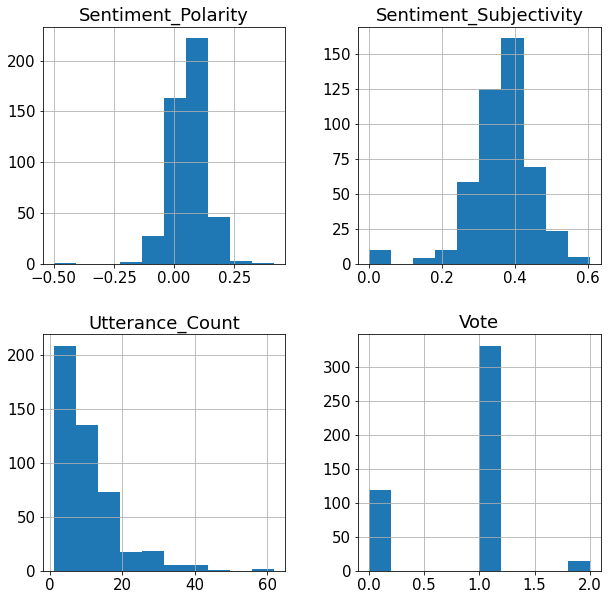

In [56]:
plt.rc ('font', size=15)
final_df.hist(figsize=(10,10))
plt.show()

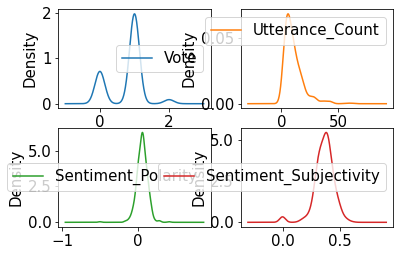

In [57]:
final_df.plot(kind='density', subplots=True, layout=(2,2), sharex=False)
plt.show()

After looking at the visualized data, several outliers or unnecessary data have emerged. The first one would be the Abstain votes, which seem to be only a small amount of votes, and can be easily removed without losing a lot of data

In [58]:
print("Sum of votes:")
print("Nil:")
print((final_df['Vote'] == 0).sum())
print("Ta:")
print((final_df['Vote'] == 1).sum())
print("Staon:")
print((final_df['Vote'] == 2).sum())
print()



Sum of votes:
Nil:
119
Ta:
331
Staon:
15



In [59]:
final_df["Vote"] = final_df["Vote"].mask(final_df["Vote"]  == 2, np.NaN)
final_df.head(20)


,Bill_Reference,Utterance,Vote,FullName,Constituency,Party,Bill_Short_Name,Bill_Type,Utterance_Count,Clean_Utterance,Sentiment_Polarity,Sentiment_Subjectivity
0,#bill.2019.99.dail.,I must now deal with a postponed division rela...,1.0,Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,3,must deal postpon divis relat second stage ren...,0.175000,0.225000
1,#bill.2019.99.dail.,"I move: ""That the Bill be now read a Second Ti...",1.0,Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,27,move bill read second time everybodi chamber k...,0.104221,0.366668
2,#bill.2019.99.dail.,Rents in the State are too high and are contin...,1.0,Denise Mitchell,Dublin-Bay-North,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2,rent state high continu rise time freez rent p...,0.093730,0.362619
3,#bill.2019.99.dail.,Renting in this economy and society is extreme...,1.0,Donnchadh Ó Laoghaire,Cork-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4,rent economi societi extrem hard even one dece...,0.015449,0.485192
4,#bill.2019.99.dail.,I said last week that people outside this Hous...,1.0,David Cullinane,Waterford,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4,said last week peopl outsid hous sick tire pol...,-0.008743,0.361981
5,#bill.2019.99.dail.,Every single day of every single week in almos...,1.0,Imelda Munster,Louth,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,3,everi singl day everi singl week almost everi ...,0.056250,0.374199
6,#bill.2019.99.dail.,"Despite what the Minister says, I am not certa...",1.0,Louise O'Reilly,Dublin-Fingal,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2,despit minist say certain truli understand imp...,0.137662,0.386607
7,#bill.2019.99.dail.,I thank Deputy Ó Broin for bringing forward th...,0.0,Eoghan Murphy,Dublin-Bay-South,Fine_Gael,Rent Freeze (Fair Rent) Bill 2019,Private Member,26,thank deputi broin bring forward bill rent hig...,0.048605,0.427677
8,#bill.2019.99.dail.,We are supporting hundreds more. The Minister ...,1.0,Aengus Ó Snodaigh,Dublin-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,7,support hundr minist misrepres newspap biggest...,-0.051488,0.401190
9,#bill.2019.99.dail.,We all know that an entire generation now risk...,1.0,Darragh O'Brien,Dublin-Fingal,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,12,know entir gener risk perman lock rental trap ...,0.057039,0.389427


In [60]:
final_df.dropna(inplace=True)
final_df.shape


(450, 12)

There was a small number of utterances that were causing an issue in the CSV (and also showed as an outlier in the visualization)

In [61]:
print("High utterance count")
print((final_df['Utterance_Count'] > 55).sum())
print()

High utterance count
2



In [62]:
final_df["Utterance_Count"] = final_df["Utterance_Count"].mask(final_df["Utterance_Count"]  > 55, np.NaN)
final_df.head(20)


,Bill_Reference,Utterance,Vote,FullName,Constituency,Party,Bill_Short_Name,Bill_Type,Utterance_Count,Clean_Utterance,Sentiment_Polarity,Sentiment_Subjectivity
0,#bill.2019.99.dail.,I must now deal with a postponed division rela...,1.0,Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,3.0,must deal postpon divis relat second stage ren...,0.175000,0.225000
1,#bill.2019.99.dail.,"I move: ""That the Bill be now read a Second Ti...",1.0,Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,27.0,move bill read second time everybodi chamber k...,0.104221,0.366668
2,#bill.2019.99.dail.,Rents in the State are too high and are contin...,1.0,Denise Mitchell,Dublin-Bay-North,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2.0,rent state high continu rise time freez rent p...,0.093730,0.362619
3,#bill.2019.99.dail.,Renting in this economy and society is extreme...,1.0,Donnchadh Ó Laoghaire,Cork-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4.0,rent economi societi extrem hard even one dece...,0.015449,0.485192
4,#bill.2019.99.dail.,I said last week that people outside this Hous...,1.0,David Cullinane,Waterford,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4.0,said last week peopl outsid hous sick tire pol...,-0.008743,0.361981
5,#bill.2019.99.dail.,Every single day of every single week in almos...,1.0,Imelda Munster,Louth,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,3.0,everi singl day everi singl week almost everi ...,0.056250,0.374199
6,#bill.2019.99.dail.,"Despite what the Minister says, I am not certa...",1.0,Louise O'Reilly,Dublin-Fingal,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2.0,despit minist say certain truli understand imp...,0.137662,0.386607
7,#bill.2019.99.dail.,I thank Deputy Ó Broin for bringing forward th...,0.0,Eoghan Murphy,Dublin-Bay-South,Fine_Gael,Rent Freeze (Fair Rent) Bill 2019,Private Member,26.0,thank deputi broin bring forward bill rent hig...,0.048605,0.427677
8,#bill.2019.99.dail.,We are supporting hundreds more. The Minister ...,1.0,Aengus Ó Snodaigh,Dublin-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,7.0,support hundr minist misrepres newspap biggest...,-0.051488,0.401190
9,#bill.2019.99.dail.,We all know that an entire generation now risk...,1.0,Darragh O'Brien,Dublin-Fingal,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,12.0,know entir gener risk perman lock rental trap ...,0.057039,0.389427


In [63]:
final_df.dropna(inplace=True)
final_df.shape


(448, 12)

On inspection of the CSV, there was a small number of utterances where the sentiment polarity was equal to 0. Upon inspection, I noticed that these were mostly short procedural statements which could be easily removed as they only made up a small number of the utterances.

In [64]:
print("Sentiment polarity:")
print("Below 0:")
print((final_df['Sentiment_Polarity'] < 0).sum())
print("Equal to 0:")
print((final_df['Sentiment_Polarity'] == 0).sum())
print("Above 0:")
print((final_df['Sentiment_Polarity'] > 0).sum())
print()


Sentiment polarity:
Below 0:
73
Equal to 0:
11
Above 0:
364



In [65]:
final_df["Sentiment_Polarity"] = final_df["Sentiment_Polarity"].mask(final_df["Sentiment_Polarity"] == 0, np.NaN)
final_df.head(20)


,Bill_Reference,Utterance,Vote,FullName,Constituency,Party,Bill_Short_Name,Bill_Type,Utterance_Count,Clean_Utterance,Sentiment_Polarity,Sentiment_Subjectivity
0,#bill.2019.99.dail.,I must now deal with a postponed division rela...,1.0,Declan Breathnach,Louth,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,3.0,must deal postpon divis relat second stage ren...,0.175000,0.225000
1,#bill.2019.99.dail.,"I move: ""That the Bill be now read a Second Ti...",1.0,Eoin Ó Broin,Dublin-Mid-West,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,27.0,move bill read second time everybodi chamber k...,0.104221,0.366668
2,#bill.2019.99.dail.,Rents in the State are too high and are contin...,1.0,Denise Mitchell,Dublin-Bay-North,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2.0,rent state high continu rise time freez rent p...,0.093730,0.362619
3,#bill.2019.99.dail.,Renting in this economy and society is extreme...,1.0,Donnchadh Ó Laoghaire,Cork-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4.0,rent economi societi extrem hard even one dece...,0.015449,0.485192
4,#bill.2019.99.dail.,I said last week that people outside this Hous...,1.0,David Cullinane,Waterford,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,4.0,said last week peopl outsid hous sick tire pol...,-0.008743,0.361981
5,#bill.2019.99.dail.,Every single day of every single week in almos...,1.0,Imelda Munster,Louth,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,3.0,everi singl day everi singl week almost everi ...,0.056250,0.374199
6,#bill.2019.99.dail.,"Despite what the Minister says, I am not certa...",1.0,Louise O'Reilly,Dublin-Fingal,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,2.0,despit minist say certain truli understand imp...,0.137662,0.386607
7,#bill.2019.99.dail.,I thank Deputy Ó Broin for bringing forward th...,0.0,Eoghan Murphy,Dublin-Bay-South,Fine_Gael,Rent Freeze (Fair Rent) Bill 2019,Private Member,26.0,thank deputi broin bring forward bill rent hig...,0.048605,0.427677
8,#bill.2019.99.dail.,We are supporting hundreds more. The Minister ...,1.0,Aengus Ó Snodaigh,Dublin-South-Central,Sinn_Féin,Rent Freeze (Fair Rent) Bill 2019,Private Member,7.0,support hundr minist misrepres newspap biggest...,-0.051488,0.401190
9,#bill.2019.99.dail.,We all know that an entire generation now risk...,1.0,Darragh O'Brien,Dublin-Fingal,Fianna_Fáil,Rent Freeze (Fair Rent) Bill 2019,Private Member,12.0,know entir gener risk perman lock rental trap ...,0.057039,0.389427


In [66]:
final_df.dropna(inplace=True)
final_df.shape

(437, 12)

In [68]:
final_df.to_csv("dail_vote.csv", index=False)


## Sources Used for Pre-Processing

Haddi, E., Liu, X. and Shi, Y. (2013) 'The Role of Text Pre-processing in Sentiment Analysis. <i>Procedia Computer Science</i>, 17, pp.26-32.

Navlani, A. (2019) 'Text Analytics for Beginners using NLTK.' <i>DataCamp</i>. Available at: <https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk> [Accessed 21 March 2021].

Sarkar, D. (2018) 'A Practitioner's Guide to Natural Language Processing (Part I) — Processing & Understanding Text.' [online] <i>Towards Data Science</i>. Available at: <https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72> [Accessed 21 March 2021].